# 4. 쳇봇엔진에 필요한 딥러닝 모델

## 4.1 Keras

* 케라스는 신경망모델 구축시 필요한 라이브러리이다.
* 설치 : pip install tensorflow

In [4]:
# MNIST분류모델학습
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

In [9]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test /  255.0 # 0~1사이의 값으로 정규화

11490434/11490434 [==============================] - 2s 0us/step


In [13]:
# tf.data를 이용하여 데이터셋을 셔플링
ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000)
train_size = int(len(X_train) * 0.7) # 학습용 : 검증용 = 7:3
train_ds = ds.take(train_size).batch(20)
val_ds = ds.skip(train_size).batch(20)

In [14]:
# MNIST분류모델
# 캐라스에서 모델을 만드는 방법은 순차모델, 함수형모델 2가지가 있다.
# 1. 모델정의
model = Sequential() # 순차모델
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(20, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="softmax"))

# 2. 모델생성
# 오차계산함수 : sparse_categorical_crossentropy
# 오차를 보정 옵티마이저 : sgd
# 측정항목 : 정확도로 설정 accuracy
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

# 3. 모델학습
hist = model.fit(train_ds, validation_data=val_ds, epochs=10)



Epoch 1/10


2100/2100 [==============================] - 6s 2ms/step - loss: 0.8394 - accuracy: 0.7545 - val_loss: 0.3993 - val_accuracy: 0.8841
Epoch 2/10
2100/2100 [==============================] - 5s 2ms/step - loss: 0.3649 - accuracy: 0.8956 - val_loss: 0.3136 - val_accuracy: 0.9081
Epoch 3/10
2100/2100 [==============================] - 5s 2ms/step - loss: 0.3027 - accuracy: 0.9137 - val_loss: 0.2729 - val_accuracy: 0.9229
Epoch 4/10
2100/2100 [==============================] - 5s 2ms/step - loss: 0.2660 - accuracy: 0.9232 - val_loss: 0.2456 - val_accuracy: 0.9267
Epoch 5/10
2100/2100 [==============================] - 5s 2ms/step - loss: 0.2405 - accuracy: 0.9293 - val_loss: 0.2256 - val_accuracy: 0.9348
Epoch 6/10
2100/2100 [==============================] - 5s 2ms/step - loss: 0.2185 - accuracy: 0.9360 - val_loss: 0.2048 - val_accuracy: 0.9399
Epoch 7/10
2100/2100 [==============================] - 4s 2ms/step - loss: 0.2021 - accuracy: 0.9412 - val_loss: 0.1978 - val_accur

In [16]:
# 4. 모델평가
model.evaluate(X_test, y_test)
model.summary()

# 5. 모델저장
model.save('./data/chatbot/mnist_modle.h5')

313/313 [==============================] - 1s 2ms/step - loss: 0.1744 - accuracy: 0.9488
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 20)                15700     
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 16330 (63.79 KB)
Trainable params: 16330 (63.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Users\EZEN\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


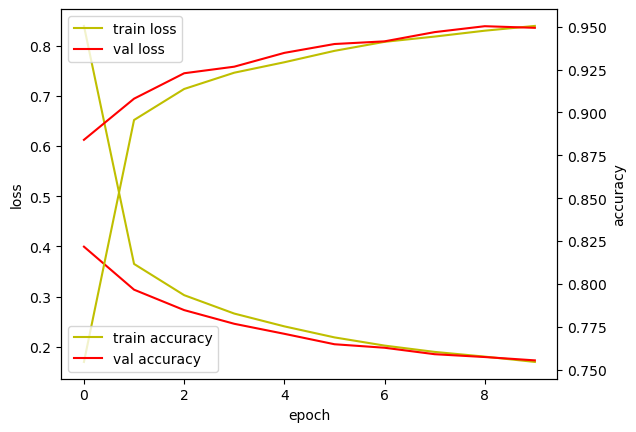

In [17]:
# 시각화
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(hist.history['loss'], 'y', label="train loss")
loss_ax.plot(hist.history['val_loss'], 'r', label="val loss")
acc_ax.plot(hist.history['accuracy'], 'y', label="train accuracy")
acc_ax.plot(hist.history['val_accuracy'], 'r', label="val accuracy")
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [18]:
# 학습된 모델 사용해서 예측하기
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [22]:
_, (X_test, y_test) = mnist.load_data()
X_test = X_test / 255.0

model = load_model('./data/chatbot/mnist_modle.h5')
model.summary()
model.evaluate(X_test, y_test, verbose=2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 20)                15700     
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 16330 (63.79 KB)
Trainable params: 16330 (63.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.1744 - accuracy: 0.9488


[0.17441339790821075, 0.9488000273704529]

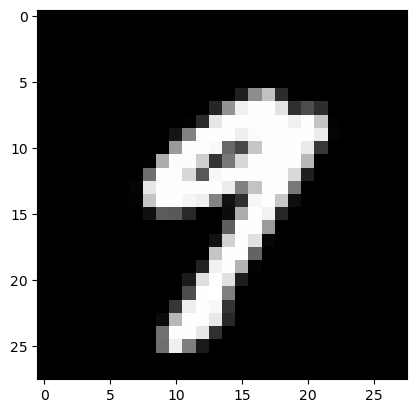

In [24]:
plt.imshow(X_test[20], cmap="gray")
plt.show()

In [26]:
# 20번째이미지 분류하기
import numpy as np
img = [20]
predict = np.argmax(model.predict(X_test[img]), axis=1)
print('손글씨 이미지의 예측 값 = ', predict)

1/1 [==============================] - 0s 26ms/step
손글씨 이미지의 예측 값 =  [9]
